# Exploring the Dataset
In this notebook, we will take a first look at the dataset to get a better idea of the data, how it could be analyzed and how it might need to be cleaned up. As we will see, this exploratory data analysis is the most important part of this project, because we are working with messy text data, which cannot otherwise be processed with most of our data analysis algorithms and tools.

In [91]:
import ast
from collections import Counter

import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
#sns.set_theme(style="darkgrid")
import pycountry

In [149]:
from tueplots import bundles
plt.rcParams.update(bundles.neurips2021(usetex=False))

First, we start by loading the data. The [Kaggle dataset description](https://www.kaggle.com/mhwong2007/drug-listing-dataset/) provides the following information about the columns:
* `product_title`: The title of the item.
* `product_description`: The description of the item. This field could be null as some of the listing archives are damaged.
* `ship_from`: The place where the item is shipped from. This field could be null as shipping information isn't required for certain marketplaces.
* `ship_to`: The place where the item is shipped to. This field could be null as shipping information isn't required for certain marketplaces.
* `seller`: The seller of the item.
* `price`: The price of the item, the currency is not yet unified.
* `source`: The name of the marketplace where this item is posted.

In [3]:
df = pd.read_csv("../dat/drug_listings.csv")
df

,product_title,product_description,ship_from,ship_to,seller,price,source
0,10mg Diazepam Tabletten - 10 Stück,- 10mg Diazepam Tabletten - 10 Stück\n\n- Disk...,Germany,Worldwide,1XAnOYMoUsX1BXx,$67.01,1776
1,10mg Diazepam Tabletten - 50 Stück,10 mg Diazepam / Valium / Valocordin Tabletten...,Germany,Worldwide,1XAnOYMoUsX1BXx,$93.82,1776
2,Sonderpreis !!! 10x Diazepam Tropfen 25ml,Diazepam / Valium / Valocordin Tropfen je Flas...,Germany,Worldwide,1XAnOYMoUsX1BXx,$938.32,1776
3,Sonderpreis !!! 2x Diazepam Tropfen 25ml,Diazepam / Valium / Valocordin Tropfen je Flas...,Germany,Worldwide,1XAnOYMoUsX1BXx,$214.46,1776
4,1 gr indian Ketamin,Very Strong Ketamin from India be careful\n\ni...,Austria,Worldwide,ACAB23,$50.00,1776
...,...,...,...,...,...,...,...
194428,∎∎ W. Domino XTC ∎∎ 220MG,White Domino XTC Pills from the Netherlands\n\...,Netherlands,NaN,"∎∎ Sensi ▬ XTC, MDMA & THC",USD 42.86\nfor 5 Pills,themarketplace
194429,∎∎ White Domino XTC ► 220mg,White Domino XTC Pills from the Netherlands\n\...,Netherlands,NaN,"∎∎ Sensi ▬ XTC, MDMA & THC",USD 42.48\nfor 5 Pills,themarketplace
194430,∎∎ White Domino XTC ► 220mg,White Domino XTC Pills from the Netherlands\n\...,Netherlands,NaN,"∎∎ Sensi ▬ XTC, MDMA & THC",USD 42.82\nfor 5 Pills,themarketplace
194431,∎∎ Yellow Grenades ∎∎ 170MG,White Domino XTC Pills from the Netherlands\n\...,Europe,NaN,"∎∎ Sensi ▬ XTC, MDMA & THC",USD 30.08\nfor 5 Pills,themarketplace


## Marketplaces

The following darknet drug marketplaces have been parsed for drug listing data:
* 1776
* Abraxas
* Agora
* Evolution
* Nucleus
* Outlaw Market
* Silk Road 2
* The Marketplace

As a first step, we can check the distribution of drug listings by marketplace. In the figure below, we can see that the [Agora marketplace](https://en.wikipedia.org/wiki/Agora_(online_marketplace)) is responsible for the majority of the listings in the dataset (around 64%, to be precise).

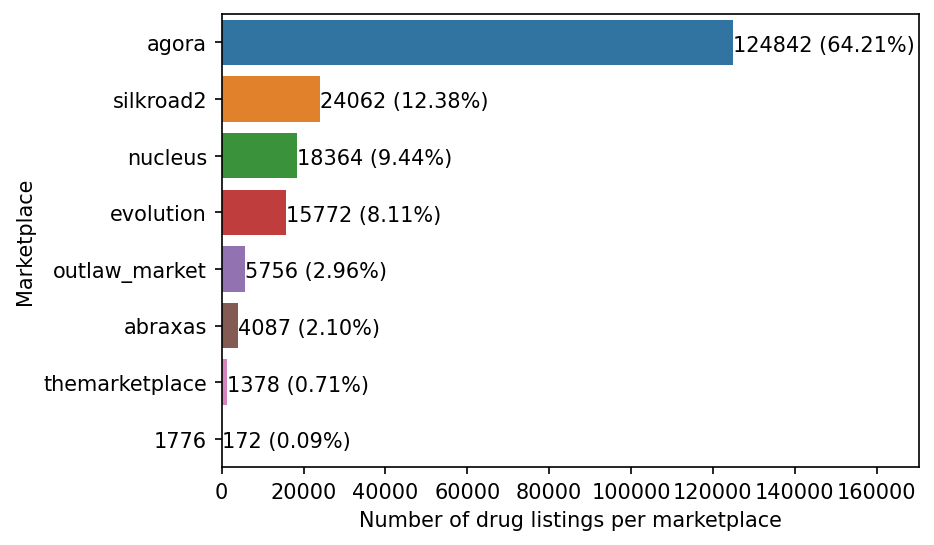

In [165]:
plt.figure(dpi=150)
ax = sns.countplot(y='source', data=df, order=df["source"].value_counts().index);
total = df["source"].value_counts().sum()
for p in ax.patches:
    percentage = 100 * p.get_width() / total
    ax.annotate(f'{p.get_width()} ({percentage:.2f}%)', (p.get_width(), p.get_y()+0.55))
xlim = plt.gca().get_xlim()
plt.xlim([xlim[0], xlim[1]*1.3])
plt.ylabel("Marketplace");
plt.xlabel("Number of drug listings per marketplace")
plt.savefig("marketplace_distribution.pdf", bbox_inches="tight")

## Sellers

Next, we can look at the top selling users on each marketplace:

Market share by top 10 sellers on 1776 marketplace: 72.67%


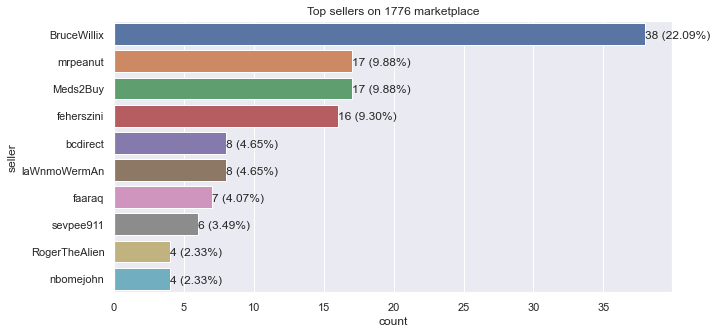

Market share by top 10 sellers on abraxas marketplace: 29.49%


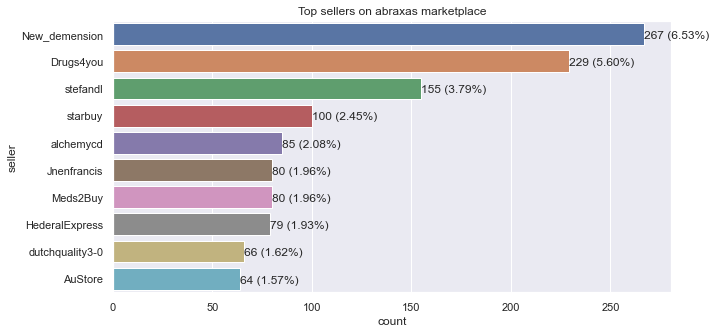

Market share by top 10 sellers on agora marketplace: 5.00%


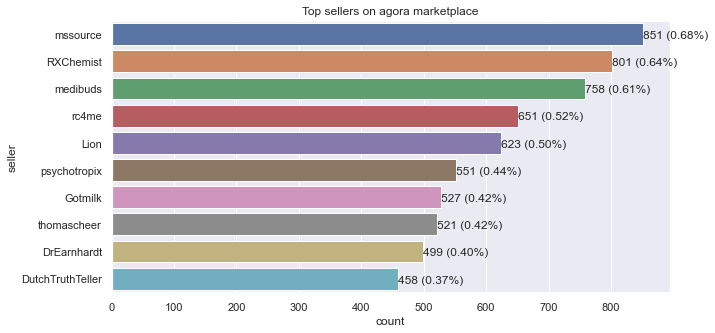

Market share by top 10 sellers on evolution marketplace: 5.80%


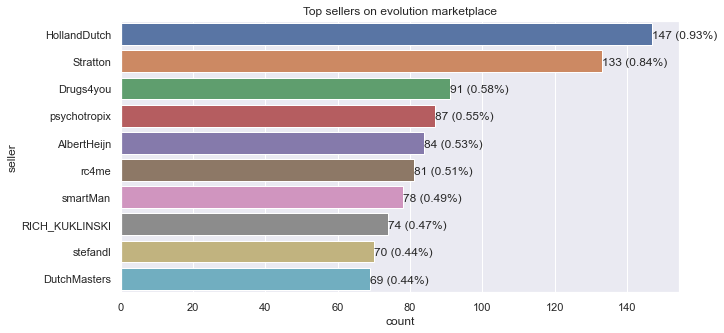

Market share by top 10 sellers on nucleus marketplace: 12.46%


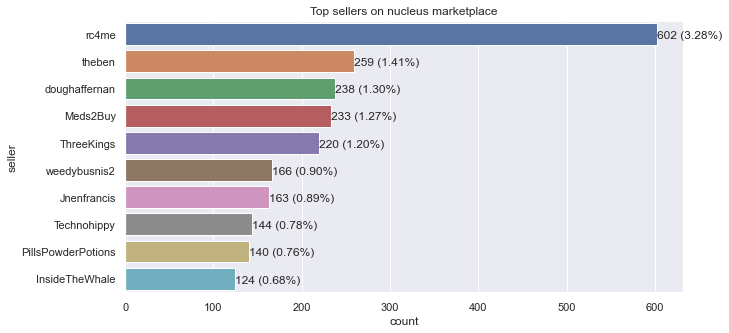

Market share by top 10 sellers on outlaw_market marketplace: 42.03%


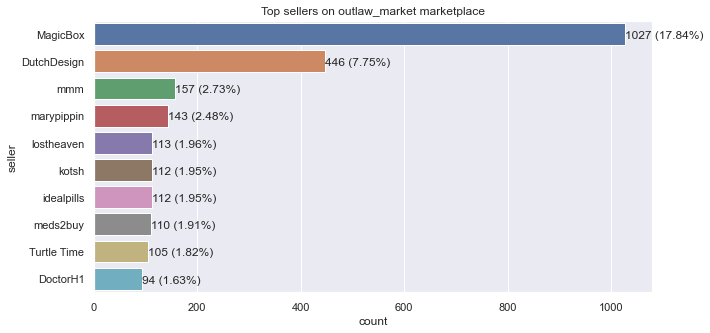

Market share by top 10 sellers on silkroad2 marketplace: 11.26%


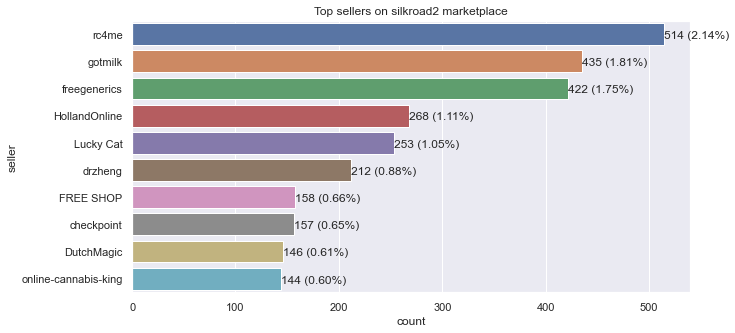

Market share by top 10 sellers on themarketplace marketplace: 26.34%


C:\Users\fredd\Anaconda3\envs\drug_data_analysis\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 8718 (\N{END OF PROOF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


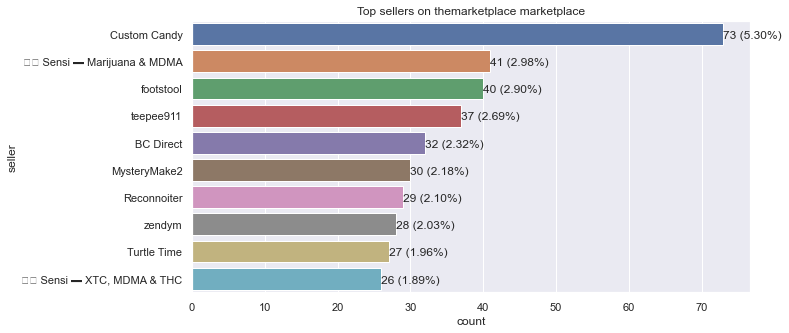

In [33]:
k = 10 # top k sellers
for marketplace in df.source.unique():
    total_top_k_market_share = 0
    plt.figure(figsize=(10, 5))
    df_for_marketplace = df[df.source == marketplace]
    ax = sns.countplot(y='seller', data=df_for_marketplace, order=df_for_marketplace["seller"].value_counts().head(k).index);
    total = df_for_marketplace["seller"].value_counts().sum()
    for p in ax.patches:
        percentage = 100 * p.get_width() / total
        total_top_k_market_share += percentage
        ax.annotate(f'{p.get_width()} ({percentage:.2f}%)', (p.get_width(), p.get_y()+0.55))
    plt.title(f"Top sellers on {marketplace} marketplace")
    print(f"Market share by top {k} sellers on {marketplace} marketplace: {total_top_k_market_share:.2f}%")
    plt.show()

We can see that the smaller marketplaces are more likely to be dominated by a few sellers (for example, the top 10 sellers in the 1776 marketplace are responsible for over 70% of the drug listings there). Another interesting observation is that the top seller on `nucleus`, `rc4me`, is the top seller on `silkroad2` and one of the top sellers on `agora` as well. Looking at the total sales regardless of marketplace below, we can see that `rc4me` is the top seller overall:

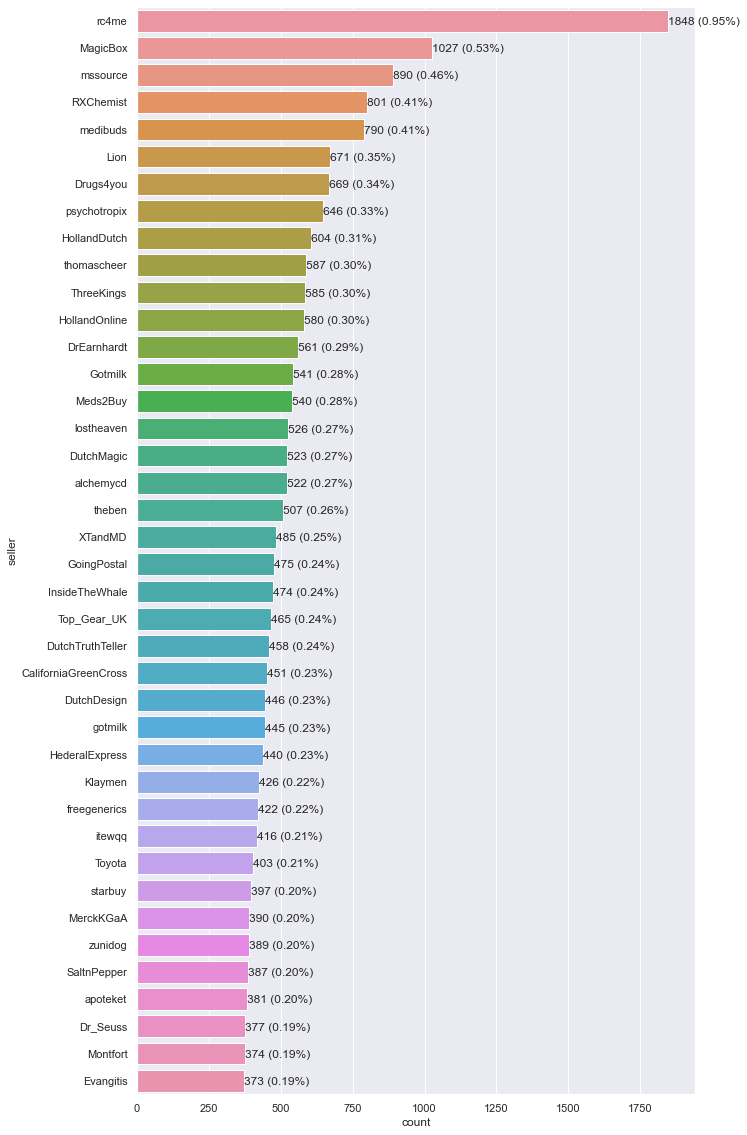

In [784]:
plt.figure(figsize=(10, 20))
ax = sns.countplot(y='seller', data=df, order=df["seller"].value_counts().head(40).index);
total = df["seller"].value_counts().sum()
for p in ax.patches:
    percentage = 100 * p.get_width() / total
    ax.annotate(f'{p.get_width()} ({percentage:.2f}%)', (p.get_width(), p.get_y()+0.55))

Let's also check whether it is common for sellers to be active on multiple marketplaces under the same name:

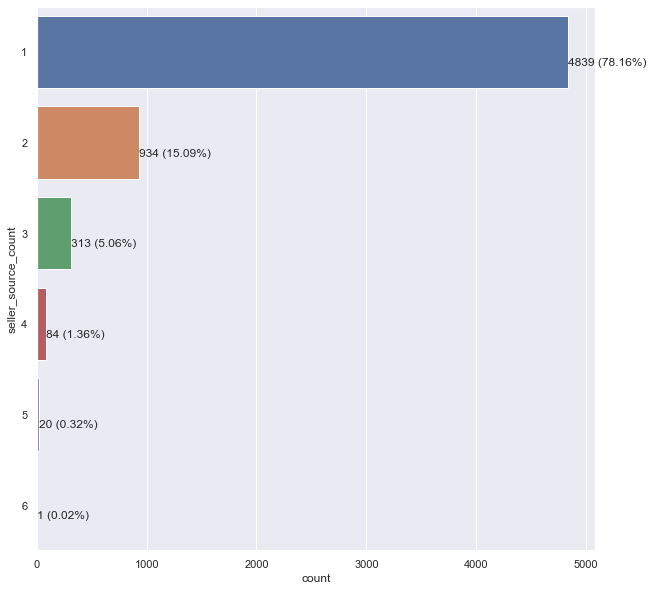

In [79]:
seller_source_value_counts = df.groupby(["seller"]).source.nunique().sort_values(ascending=False).rename("seller_source_count").to_frame()

plt.figure(figsize=(10, 10))
ax = sns.countplot(y='seller_source_count', 
                   data=seller_source_value_counts, 
                   order=seller_source_value_counts["seller_source_count"].value_counts().head(40).index);
total = seller_source_value_counts["seller_source_count"].value_counts().sum()
for p in ax.patches:
    percentage = 100 * p.get_width() / total
    ax.annotate(f'{p.get_width()} ({percentage:.2f}%)', (p.get_width(), p.get_y()+0.55))

Most sellers are only active on one marketplace.

Also, maybe there is a correlation between the amount of listings of a seller and the number of marketplaces he is active on (e.g. top sellers are usually active on multiple marketplaces)? Let's check this out with a box plot:

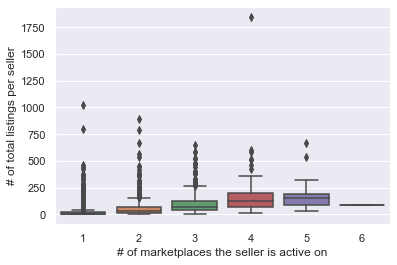

In [120]:
sns.boxplot(y=df["seller"].value_counts(), x=seller_source_value_counts["seller_source_count"]);
plt.xlabel("# of marketplaces the seller is active on")
plt.ylabel("# of total listings per seller");

As you might expect, sellers that are active on multiple marketplaces seem to have more listings overall.

## Shipping information

Another information present in the dataset are the `ship_from` column (indicating where an item is shipped from) and the `ship_from` column (indicating where an item is shipped to). This information could be very interesting for later analysis, since it might allow exploration of questions such as:
* Which countries ship the most drugs?
* (How) do drug prices differ from country to country?
* Are there certain characteristics of a country that correlate with the number of drugs available there? (e.g. GDP, prevalence of mental health issues, ...)

However, when looking at the contents of these country columns (see plot below), we can see they are quite messy: Countries are referred to by different names (e.g. `DE-GERMANY` and `Germany`), by 2-letter and 3-letter country codes (e.g. `GB`, `US`, `USA`) or sometimes grouped as regions (e.g. `European Union` or `Worldwide`).

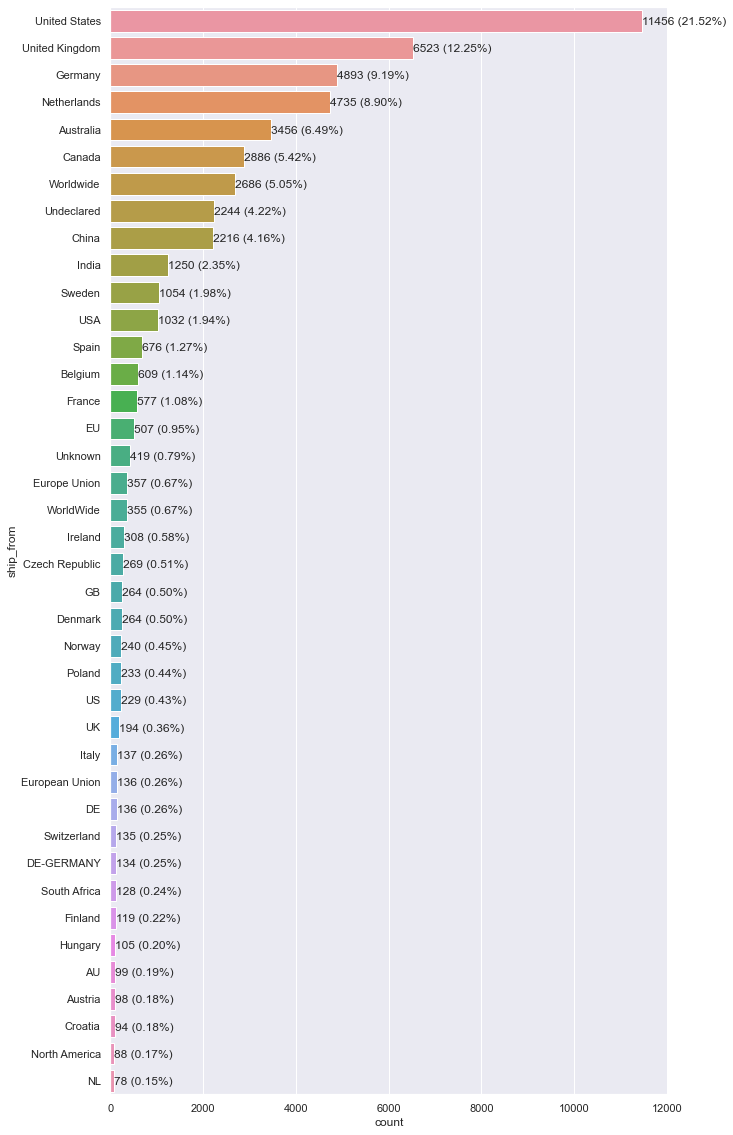

In [4]:
plt.figure(figsize=(10, 20))
ax = sns.countplot(y='ship_from', data=df, order=df["ship_from"].value_counts().head(40).index);
total = df["ship_from"].value_counts().sum()
for p in ax.patches:
    percentage = 100 * p.get_width() / total
    ax.annotate(f'{p.get_width()} ({percentage:.2f}%)', (p.get_width(), p.get_y()+0.55))

The `ship_to` column has similar issues. Additionally, some sellers apparently list all the countries where the item *can* be shipped to as a long list in the `ship_to` column, making it even harder to calculate the same counts as before.

> One could argue that the information in the `ship_to` column is not meaningful - it simply states where a drug *can* be shipped to (worldwide in most cases), not where it *will* actually be shipped to. As such, it does not allow a direct conclusion about the number of drugs that are being ordered in a given country. However, the information might actually give an indirect idea of which countries have the most darknet drug customers, since one would expect an increased supply (i.e. availability of shipping in our case) to correlate with an increased demand. For this reason, we choose to clean up this column as well.

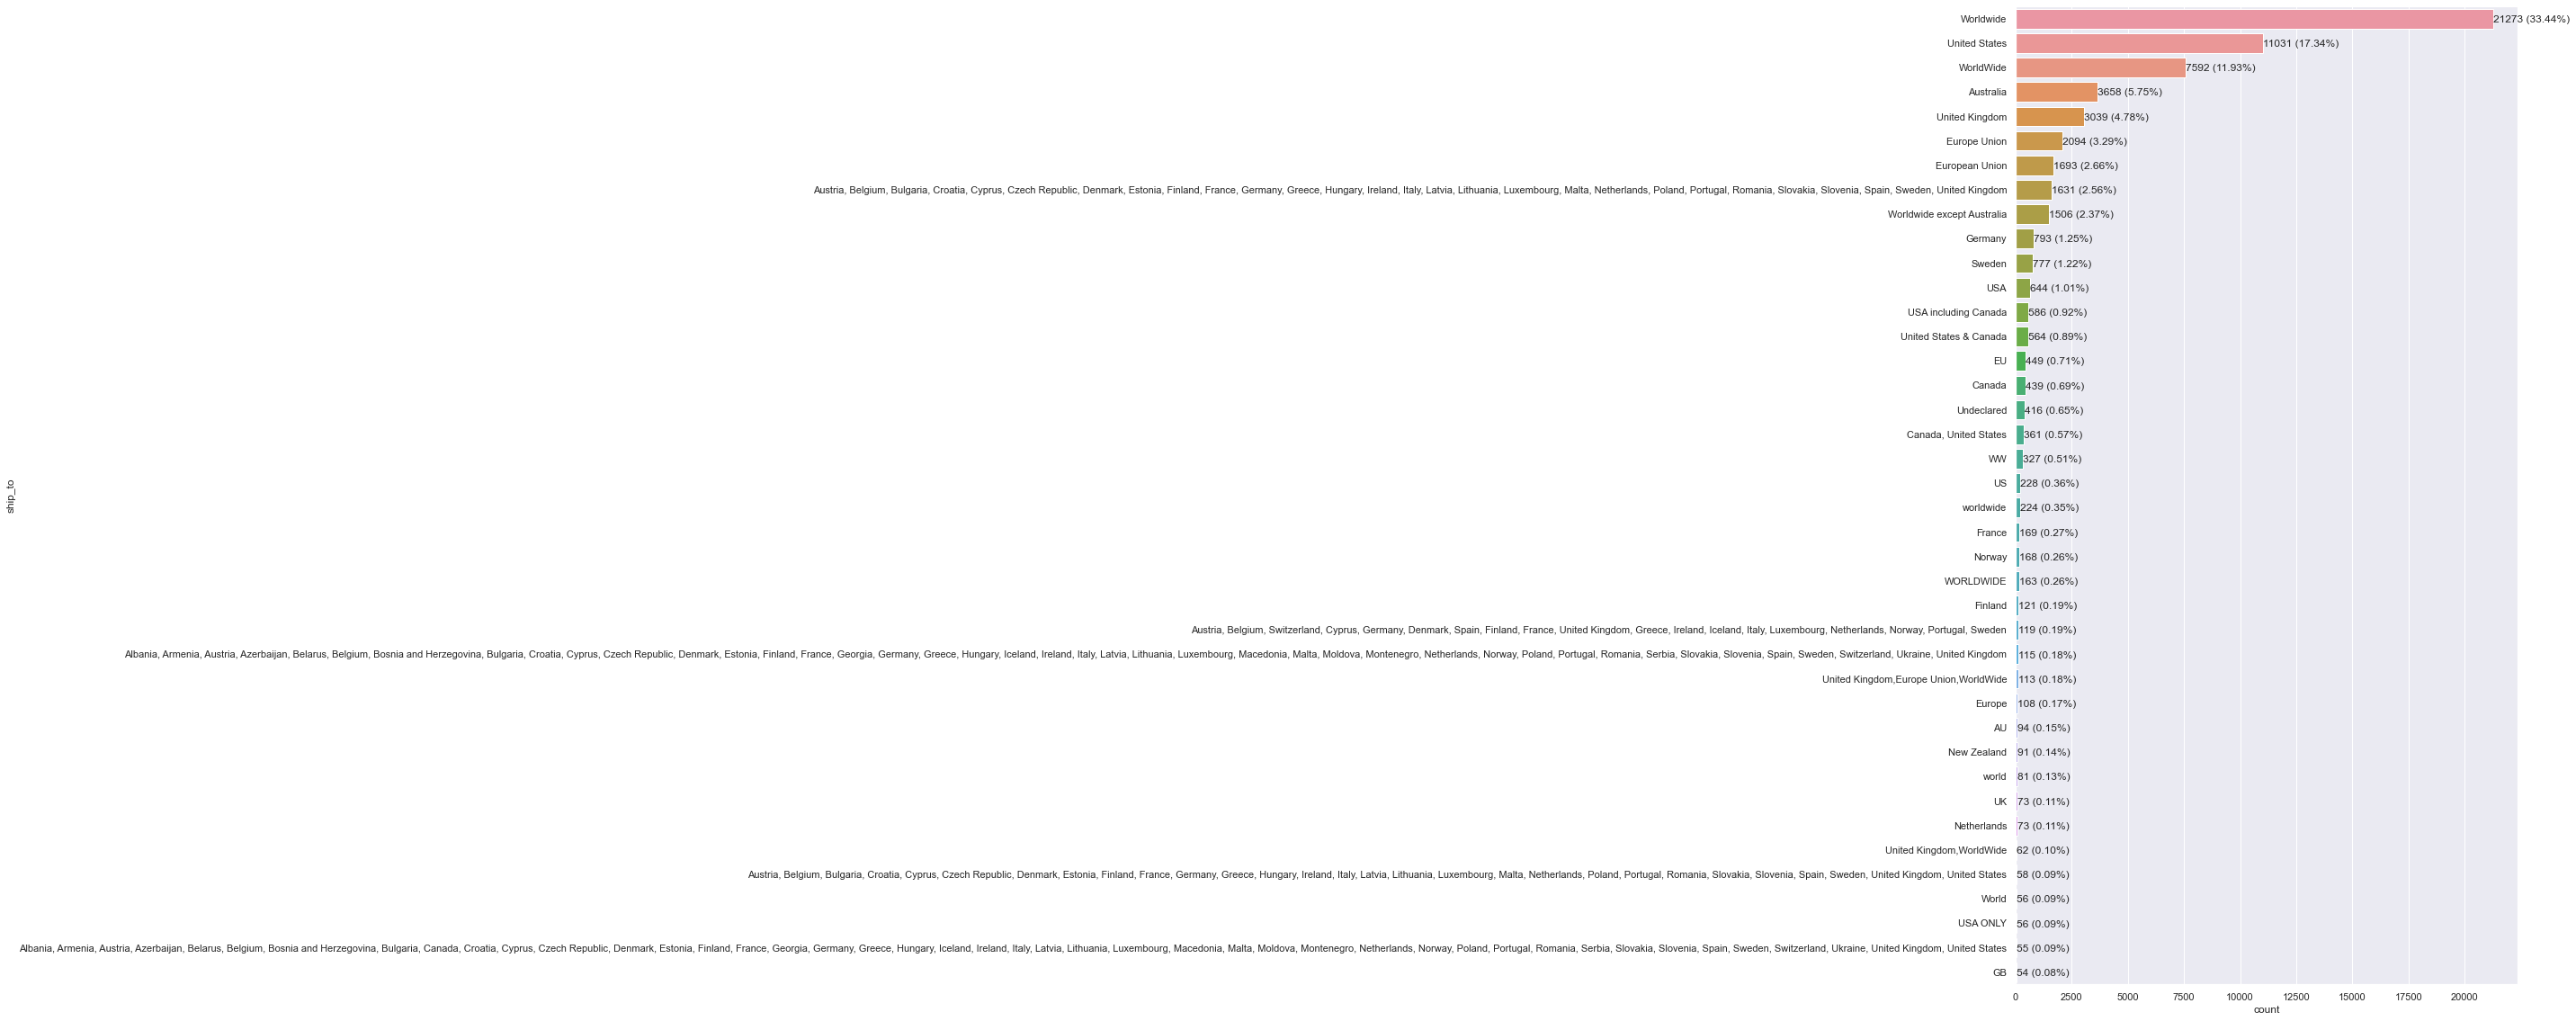

In [86]:
plt.figure(figsize=(10, 20))
ax = sns.countplot(y='ship_to', data=df, order=df["ship_to"].value_counts().head(40).index);
total = df["ship_to"].value_counts().sum()
for p in ax.patches:
    percentage = 100 * p.get_width() / total
    ax.annotate(f'{p.get_width()} ({percentage:.2f}%)', (p.get_width(), p.get_y()+0.55))

To make full use of the information in these country columns, we need to somehow standardize/group the different representations of country names into a common format. For this, we will use the [pycountry](https://pypi.org/project/pycountry/) library:

In [4]:
def find_country(search_term):
    """ Finds a country in the pycountry library using the given search term. If found, returns its 3-letter alphabetic code, else returns None. 
    
    """
    if pd.isna(search_term):
        # search_term is np.NaN or similar
        return None
    try:
        return pycountry.countries.search_fuzzy(search_term)[0].alpha_3
    except LookupError:
        return None

We will use the function above to try and find a matching country given each `ship_from` entry:

In [108]:
# Running this cell can take a few hours
#df["ship_from_alpha_3"] = df["ship_from"].apply(lambda country: find_country(country))
#df

,product_title,product_description,ship_from,ship_to,seller,price,source,ship_from_alpha_3
0,10mg Diazepam Tabletten - 10 Stück,- 10mg Diazepam Tabletten - 10 Stück\n\n- Disk...,Germany,Worldwide,1XAnOYMoUsX1BXx,$67.01,1776,DEU
1,10mg Diazepam Tabletten - 50 Stück,10 mg Diazepam / Valium / Valocordin Tabletten...,Germany,Worldwide,1XAnOYMoUsX1BXx,$93.82,1776,DEU
2,Sonderpreis !!! 10x Diazepam Tropfen 25ml,Diazepam / Valium / Valocordin Tropfen je Flas...,Germany,Worldwide,1XAnOYMoUsX1BXx,$938.32,1776,DEU
3,Sonderpreis !!! 2x Diazepam Tropfen 25ml,Diazepam / Valium / Valocordin Tropfen je Flas...,Germany,Worldwide,1XAnOYMoUsX1BXx,$214.46,1776,DEU
4,1 gr indian Ketamin,Very Strong Ketamin from India be careful\n\ni...,Austria,Worldwide,ACAB23,$50.00,1776,AUT
...,...,...,...,...,...,...,...,...
194428,∎∎ W. Domino XTC ∎∎ 220MG,White Domino XTC Pills from the Netherlands\n\...,Netherlands,NaN,"∎∎ Sensi ▬ XTC, MDMA & THC",USD 42.86\nfor 5 Pills,themarketplace,NLD
194429,∎∎ White Domino XTC ► 220mg,White Domino XTC Pills from the Netherlands\n\...,Netherlands,NaN,"∎∎ Sensi ▬ XTC, MDMA & THC",USD 42.48\nfor 5 Pills,themarketplace,NLD
194430,∎∎ White Domino XTC ► 220mg,White Domino XTC Pills from the Netherlands\n\...,Netherlands,NaN,"∎∎ Sensi ▬ XTC, MDMA & THC",USD 42.82\nfor 5 Pills,themarketplace,NLD
194431,∎∎ Yellow Grenades ∎∎ 170MG,White Domino XTC Pills from the Netherlands\n\...,Europe,NaN,"∎∎ Sensi ▬ XTC, MDMA & THC",USD 30.08\nfor 5 Pills,themarketplace,None


The `ship_to` column is slightly more complicated because it can contain multiple countries:

In [50]:
def replace_each_country_in_list_with_alpha_3(country_list_string):
    if pd.isna(country_list_string):
        # country_list_string is np.NaN or similar
        return None
    
    country_list = country_list_string.split(",")
    alpha_3_country_list = []
    for country in country_list:
        alpha_3_country = find_country(country)
        if alpha_3_country:
            alpha_3_country_list.append(alpha_3_country)
    if len(alpha_3_country_list) == 0:
        return None
    else:
        return ",".join(alpha_3_country_list)

In [69]:
# Running this cell can take a few hours
#df["ship_to_alpha_3"] = df["ship_to"].apply(replace_each_country_in_list_with_alpha_3)
#df

,product_title,product_description,ship_from,ship_to,seller,price,source,ship_to_alpha_3
0,10mg Diazepam Tabletten - 10 Stück,- 10mg Diazepam Tabletten - 10 Stück\n\n- Disk...,Germany,Worldwide,1XAnOYMoUsX1BXx,$67.01,1776,None
1,10mg Diazepam Tabletten - 50 Stück,10 mg Diazepam / Valium / Valocordin Tabletten...,Germany,Worldwide,1XAnOYMoUsX1BXx,$93.82,1776,None
2,Sonderpreis !!! 10x Diazepam Tropfen 25ml,Diazepam / Valium / Valocordin Tropfen je Flas...,Germany,Worldwide,1XAnOYMoUsX1BXx,$938.32,1776,None
3,Sonderpreis !!! 2x Diazepam Tropfen 25ml,Diazepam / Valium / Valocordin Tropfen je Flas...,Germany,Worldwide,1XAnOYMoUsX1BXx,$214.46,1776,None
4,1 gr indian Ketamin,Very Strong Ketamin from India be careful\n\ni...,Austria,Worldwide,ACAB23,$50.00,1776,None
...,...,...,...,...,...,...,...,...
194428,∎∎ W. Domino XTC ∎∎ 220MG,White Domino XTC Pills from the Netherlands\n\...,Netherlands,NaN,"∎∎ Sensi ▬ XTC, MDMA & THC",USD 42.86\nfor 5 Pills,themarketplace,None
194429,∎∎ White Domino XTC ► 220mg,White Domino XTC Pills from the Netherlands\n\...,Netherlands,NaN,"∎∎ Sensi ▬ XTC, MDMA & THC",USD 42.48\nfor 5 Pills,themarketplace,None
194430,∎∎ White Domino XTC ► 220mg,White Domino XTC Pills from the Netherlands\n\...,Netherlands,NaN,"∎∎ Sensi ▬ XTC, MDMA & THC",USD 42.82\nfor 5 Pills,themarketplace,None
194431,∎∎ Yellow Grenades ∎∎ 170MG,White Domino XTC Pills from the Netherlands\n\...,Europe,NaN,"∎∎ Sensi ▬ XTC, MDMA & THC",USD 30.08\nfor 5 Pills,themarketplace,None


In [4]:
#df = pd.read_csv("../dat/drug_listings_cleaned.csv", index_col=0)
#df

,product_title,product_description,ship_from,ship_to,seller,price,source,ship_to_alpha_3,ship_from_alpha_3,drug_name
0,10mg Diazepam Tabletten - 10 Stück,- 10mg Diazepam Tabletten - 10 Stück\n\n- Disk...,Germany,Worldwide,1XAnOYMoUsX1BXx,$67.01,1776,NaN,DEU,Valium
1,10mg Diazepam Tabletten - 50 Stück,10 mg Diazepam / Valium / Valocordin Tabletten...,Germany,Worldwide,1XAnOYMoUsX1BXx,$93.82,1776,NaN,DEU,Valium
2,Sonderpreis !!! 10x Diazepam Tropfen 25ml,Diazepam / Valium / Valocordin Tropfen je Flas...,Germany,Worldwide,1XAnOYMoUsX1BXx,$938.32,1776,NaN,DEU,Valium
3,Sonderpreis !!! 2x Diazepam Tropfen 25ml,Diazepam / Valium / Valocordin Tropfen je Flas...,Germany,Worldwide,1XAnOYMoUsX1BXx,$214.46,1776,NaN,DEU,Valium
4,1 gr indian Ketamin,Very Strong Ketamin from India be careful\n\ni...,Austria,Worldwide,ACAB23,$50.00,1776,NaN,AUT,Ketamine
...,...,...,...,...,...,...,...,...,...,...
194428,∎∎ W. Domino XTC ∎∎ 220MG,White Domino XTC Pills from the Netherlands\n\...,Netherlands,NaN,"∎∎ Sensi ▬ XTC, MDMA & THC",USD 42.86\nfor 5 Pills,themarketplace,NaN,NLD,MDMA
194429,∎∎ White Domino XTC ► 220mg,White Domino XTC Pills from the Netherlands\n\...,Netherlands,NaN,"∎∎ Sensi ▬ XTC, MDMA & THC",USD 42.48\nfor 5 Pills,themarketplace,NaN,NLD,MDMA
194430,∎∎ White Domino XTC ► 220mg,White Domino XTC Pills from the Netherlands\n\...,Netherlands,NaN,"∎∎ Sensi ▬ XTC, MDMA & THC",USD 42.82\nfor 5 Pills,themarketplace,NaN,NLD,MDMA
194431,∎∎ Yellow Grenades ∎∎ 170MG,White Domino XTC Pills from the Netherlands\n\...,Europe,NaN,"∎∎ Sensi ▬ XTC, MDMA & THC",USD 30.08\nfor 5 Pills,themarketplace,NaN,NaN,MDMA


After cleaning the columns, we can now repeat the count plots for each column:

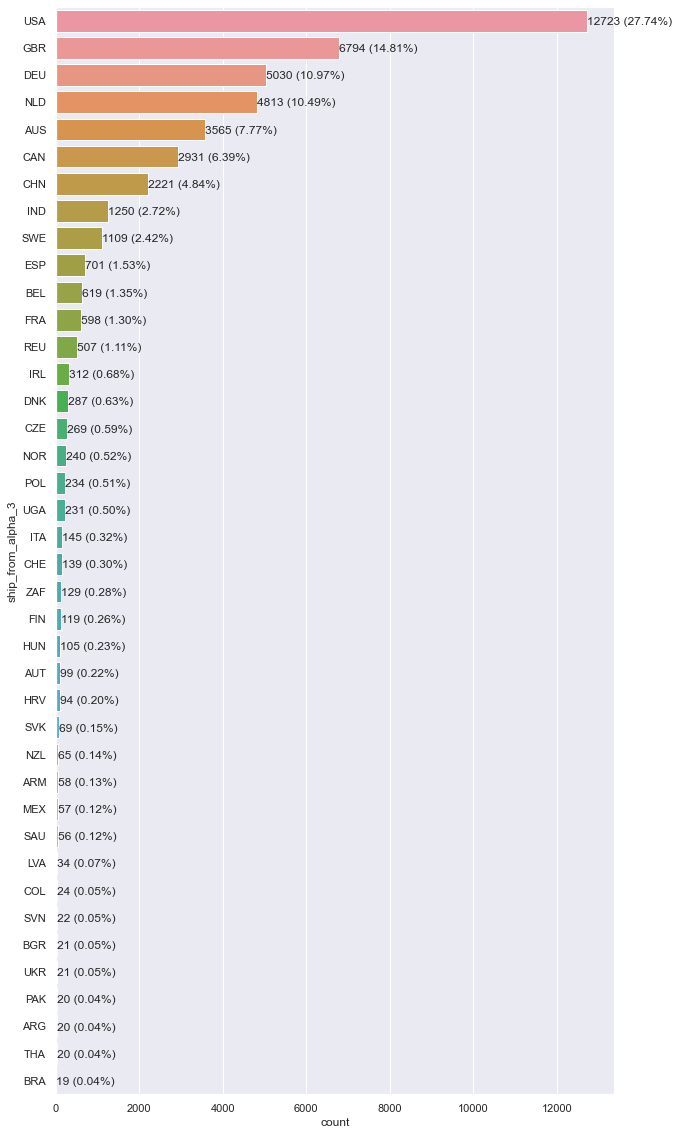

In [5]:
plt.figure(figsize=(10, 20))
ax = sns.countplot(y='ship_from_alpha_3', data=df, order=df["ship_from_alpha_3"].value_counts().head(40).index);
total = df["ship_from_alpha_3"].value_counts().sum()
for p in ax.patches:
    percentage = 100 * p.get_width() / total
    ax.annotate(f'{p.get_width()} ({percentage:.2f}%)', (p.get_width(), p.get_y()+0.55))

In [77]:
sample = df[df.ship_to.notna()].sample(1)
sample

,product_title,product_description,ship_from,ship_to,seller,price,source,ship_to_alpha_3,ship_from_alpha_3,drug_name
137201,14 Grams Trainwreck Mid Shelf Premium Marijuan...,14 Grams of StrattonOakmont's Premium Outdoor ...,United States,United States,Stratton,BTC 0.3175,evolution,USA,USA,Cannabis


In [86]:
sample.T.to_csv("sample.csv")

In [87]:
pd.read_csv("sample.csv")

,Unnamed: 0,137201
0,product_title,14 Grams Trainwreck Mid Shelf Premium Marijuan...
1,product_description,14 Grams of StrattonOakmont's Premium Outdoor ...
2,ship_from,United States
3,ship_to,United States
4,seller,Stratton
5,price,BTC 0.3175
6,source,evolution
7,ship_to_alpha_3,USA
8,ship_from_alpha_3,USA
9,drug_name,Cannabis


In [79]:
print(sample.product_title.iloc[0])

14 Grams Trainwreck Mid Shelf Premium Marijuana NO FE


In [78]:
print(sample.product_description.iloc[0])

14 Grams of StrattonOakmont's Premium Outdoor Washington Medical Marijuana



Strain:  Trainwreck

Type:  Indica Dominant



  Another very nice premium outdoor strain, surprisingly potent for the price.  Dark green nugs with orange hairs, generally ranging from medium to large in size and has a nice darker smell.  Product is seedless and with minimal stem.

  Price reflects quality - Higher resolution photos available below.





Higher Resolution Photos



https://cdn.mediacru.sh/qUuxr8aczvXg.jpg

https://cdn.mediacru.sh/4EWw9JM3VPhq.jpg

https://cdn.mediacru.sh/X7zIijxpdoxy.jpg

https://cdn.mediacru.sh/yIhD-UicIX6o.jpg





Shipping



USA Domestic Only



Shipping is an additional charge for the first order, all additional items are eligible for free shipping as they will be mailed in one package (up to 56g total).  

Priority Mail (2-3 business days):    $8.00

Combined Shipping (2+ items only):    $0.00



Encrypting your address:

*Please include a full name and format properly


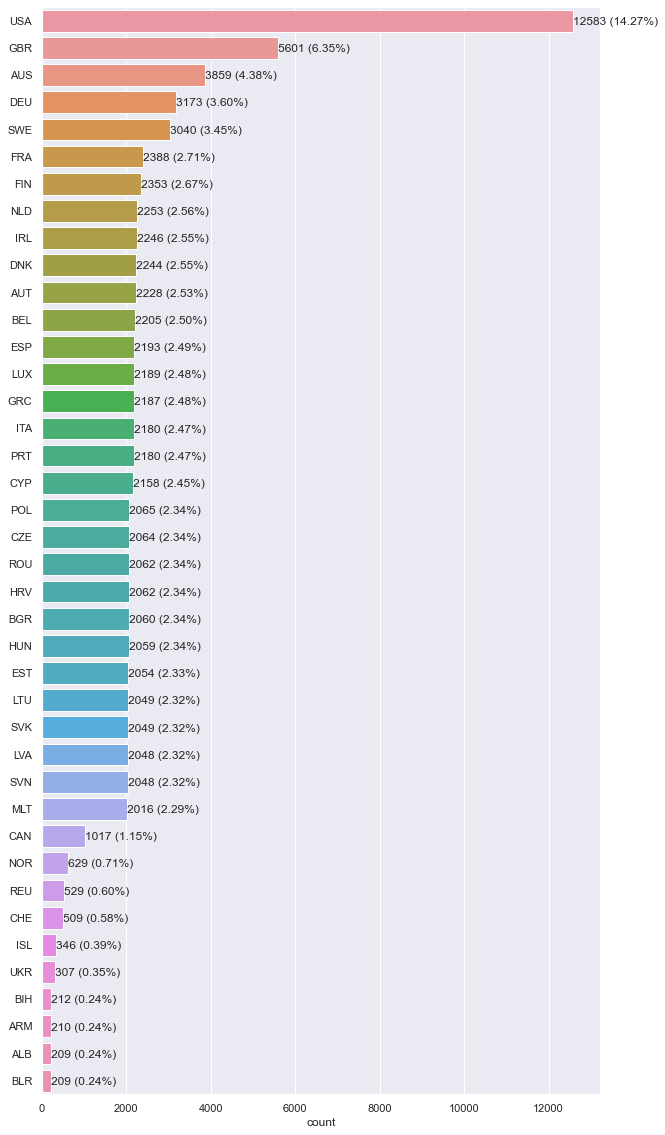

In [109]:
# for ship_to, we need to count them slightly differently
ship_to_alpha_3 = df["ship_to_alpha_3"].dropna()
ship_to_countries = ship_to_alpha_3.str.split(",")
all_ship_to_countries = [country for cntries in ship_to_countries for country in cntries]
country_count = Counter(all_ship_to_countries)

plt.figure(figsize=(10, 20))
ax = sns.countplot(y=all_ship_to_countries, order=[k for k, _ in country_count.most_common()][:40])
total = sum([c for _, c in country_count.most_common()])
for p in ax.patches:
    percentage = 100 * p.get_width() / total
    ax.annotate(f'{p.get_width()} ({percentage:.2f}%)', (p.get_width(), p.get_y()+0.55))

We should note here that upon further inspection, we can see that a lot of the listings have no country information at all (`ship_from` as well as `ship_to`):

In [113]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194433 entries, 0 to 194432
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   product_title        194429 non-null  object
 1   product_description  180439 non-null  object
 2   ship_from            53229 non-null   object
 3   ship_to              63623 non-null   object
 4   seller               194303 non-null  object
 5   price                193947 non-null  object
 6   source               194433 non-null  object
 7   ship_to_alpha_3      25662 non-null   object
 8   ship_from_alpha_3    45873 non-null   object
dtypes: object(9)
memory usage: 13.4+ MB


This means that we are left with a significantly smaller dataset, which also completely changes the distribution of drug marketplaces in the dataset:

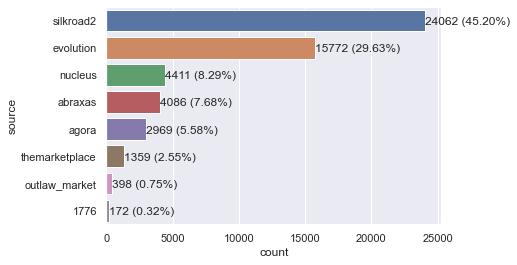

In [8]:
ship_from_info_available = df["ship_from"].notnull()
ax = sns.countplot(y='source', data=df[ship_from_info_available], order=df[ship_from_info_available]["source"].value_counts().index);
total = df[ship_from_info_available]["source"].value_counts().sum()
for p in ax.patches:
    percentage = 100 * p.get_width() / total
    ax.annotate(f'{p.get_width()} ({percentage:.2f}%)', (p.get_width(), p.get_y()+0.55))

## Drug type

The `product_title` and `product_description` columns contain information about the drug being sold (e.g. Cannabis, Cocaine, MDMA, ...). However, this information is very unstructured - to make any statistics about *which* drugs are sold, we first need to parse the titles and descriptions for the names of the drugs we want to look at.

In [119]:
# a few examples of drug listing titles and descriptions
for _ in range(3):
    smple = df.sample(1)
    print(f"TITLE: {smple.product_title.iloc[0]}\n" )
    print(f"DESCRIPTION: {smple.product_description.iloc[0]} \n")
    print("=======================================================")

TITLE: 30 mg - Oxycodone "M" Brand

DESCRIPTION: *** BEST PRICE ON DEEP WEB ***
*** PLEASE READ OUR PROFILE PAGE PRIOR TO PLACING AN ORDER ***
*** MINIMUM ORDER IS 5 UNITS ***
This is a relationship based business where reputation is paramount. We understand the value of positive feedback and will do everything in our power to ensure your satisfaction.
This listing is for the highly coveted "M" brand, 30 mg Oxycodone. 
We want your business.  As always, we are more than happy to answer any and all questions.
We pride ourselves on getting your order to you as quickly as possible. We ask, in return, that you finalize escrow immediately upon product arrival. 

TITLE: 2 gr -- Pure Power Plant -- (Indoor)

DESCRIPTION: No refund/reships given when lost or not received. Only 1 per person.
Pure Power Plant ( http://sensiseeds.com )
2 gram
Indoor growed with much care!
This is pure power plant, high quality! definitely A+++ grade. NO kidding!
This strain is again organically grown with no chem

Below, we have done this manual parsing for some the most common drugs in the dataset by doing simple pattern matching with various names for the same drug:

In [112]:
def replace_if_matches(series, term_list):
    new_series_with_grouped_terms = series.copy()
    for term in term_list:
        new_series_with_grouped_terms[series.str.lower().str.contains(term).fillna(False)] = term + "_GROUP"
    return new_series_with_grouped_terms

In [119]:
# list of opioids from https://www.hopkinsmedicine.org/opioids/what-are-opioids.html
opioids_dict = {
    "heroin": "Heroine",
    "oxycodon|oxycontin|roxicodone|oxecta|oxaydo|xtampza|percodan|targiniq|xartemis|oxycet|roxicet|tylox|percocet": "Oxycodone",
    "hydrocodone-acetaminophen|vicodin|norco|lorcet|zamicet|verdrocet|lortab|anexsia|co-gesic|hycet|liquicet|maxidone|norco|xodol|zolvit|zydone": "Hydrocodone-Acetaminophen",
    r"hydrocodone\sbitartrate|sysingla|zohydro": "Hydrocodone bitartrate",
    "hydrocodone-homatropine|hycodan|hydromet": "Hydrocodone-Homatropine",
    "hydrocodone-ibuprofen|ibudone|xylon|reprexain|vicoprofen": "Hydrocodone-Ibuprofen",
    "pseudoephedrine-hydrocodone|rezira": "Pseudoephedrine-Hydrocodone",
    "hydrocodone-clorpheniramine|vituz": "Hydrocodone-Clorpheniramine",
    "hydrocodone-cpm-pseudoephed|zutripro": "Hydrocodone-Cpm-Pseudoephed",
    "morphine-naltrexone|embeda": "Morphine-Naltrexone",
    r"morphin\b|morphine\b|duramorph|infumorph|ms\scontin|oramorph|avinza|arymo|kadian|morphabond|roxanol-t": "Morphine",
    "hydromorphon|dilaudid|exalgo|palladone": "Hydromorphone",
    r"fentanylcitrat|fentanyl\scitrate|actiq|fentora|abstral|lazanda|onsolis|sublimaze": "Fentanyl Citrate",
    "fentanyl|duragesic|subsys": "Fentanyl",
    "codeine\spoli-chlorphenir\spoli|tuzistra": "Codeine Poli-Chlorphenir Poli",
    "acetaminophen-codeine": "Acetaminophen-Codeine",
    "methadon|dolophine|methadose": "Methadone",
    "oxymorphone\shydrochloride|opana": "Oxymorphone Hydrochloride",
    "tramadol": "Tramadol",
    "carfentanil|carfentanyl": "Carfentanil",
    "buprenorphin|subatex|buprenex|butrans|probuphine|suboxone": "Buprenorphine"
}

In [127]:
amphetamines_dict = {
    "adderal|ritalin": "Adderall/Ritalin",
    "mdma|molly|xtc|ecstasy": "MDMA", 
    "speed|meth": "Meth",
    "mephedron": "Mephedrone",
    "amphetamin|dextrostat|dexedrin|zenzedi|concerta|procentra|vyvanse|focalin|strattera|desoxyn|metadate|methylin": "Other Amphetamines",
}

In [128]:
drug_regexp_to_name_dict = {
    "cocain|kokain|koks|coke": "Cocaine",
    "mariju|cannabis|weed|haze|hash|hasch|kush|indica|sativa|thc|bud$|buds|kief|skunk|strain": "Cannabis", 
    "lsd": "LSD", 
    "ketamin": "Ketamine", 
    "mushroom": "Mushrooms", 
    "xanax|alprazolam": "Xanax", 
    "2cb|2c-b": "2C-B", 
    "steroid|anabolic": "Steroids", 
    "viagra": "Viagra", 
    "valium|diazepam": "Valium", 
    "ghb": "GHB", 
    "dmt": "DMT", 
    "nbome": "NBOMe", 
    "clonazepam|rivotril": "Clonazepame", 
    "spice": "Spice", 
    "cigarette": "Cigarettes", 
    "zolpidem|ambien": "Ambien", 
    "modafinil": "Modafinil"
}

drug_regexp_to_name_dict.update(opioids_dict)
drug_regexp_to_name_dict.update(amphetamines_dict)

grouped_product_titles = replace_if_matches(df["product_title"], list(drug_regexp_to_name_dict.keys()))
grouped_product_descs = replace_if_matches(df["product_description"], list(drug_regexp_to_name_dict.keys()))

drug_names = grouped_product_titles
drug_names.loc[~drug_names.str.contains("_GROUP").fillna(False)] = grouped_product_descs # if nothing was found in title, use what was found in description
drug_names = drug_names[drug_names.str.contains("_GROUP").fillna(False)]
drug_names = drug_names.replace("_GROUP", "", regex=True)
drug_names = drug_names.replace(drug_regexp_to_name_dict)

We add this information to the cleaned dataset so that we can use it later on:

In [129]:
df["drug_name"] = drug_names
df

,product_title,product_description,ship_from,ship_to,seller,price,source,ship_to_alpha_3,ship_from_alpha_3,drug_name
0,10mg Diazepam Tabletten - 10 Stück,- 10mg Diazepam Tabletten - 10 Stück\n\n- Disk...,Germany,Worldwide,1XAnOYMoUsX1BXx,$67.01,1776,NaN,DEU,Valium
1,10mg Diazepam Tabletten - 50 Stück,10 mg Diazepam / Valium / Valocordin Tabletten...,Germany,Worldwide,1XAnOYMoUsX1BXx,$93.82,1776,NaN,DEU,Valium
2,Sonderpreis !!! 10x Diazepam Tropfen 25ml,Diazepam / Valium / Valocordin Tropfen je Flas...,Germany,Worldwide,1XAnOYMoUsX1BXx,$938.32,1776,NaN,DEU,Valium
3,Sonderpreis !!! 2x Diazepam Tropfen 25ml,Diazepam / Valium / Valocordin Tropfen je Flas...,Germany,Worldwide,1XAnOYMoUsX1BXx,$214.46,1776,NaN,DEU,Valium
4,1 gr indian Ketamin,Very Strong Ketamin from India be careful\n\ni...,Austria,Worldwide,ACAB23,$50.00,1776,NaN,AUT,Ketamine
...,...,...,...,...,...,...,...,...,...,...
194428,∎∎ W. Domino XTC ∎∎ 220MG,White Domino XTC Pills from the Netherlands\n\...,Netherlands,NaN,"∎∎ Sensi ▬ XTC, MDMA & THC",USD 42.86\nfor 5 Pills,themarketplace,NaN,NLD,MDMA
194429,∎∎ White Domino XTC ► 220mg,White Domino XTC Pills from the Netherlands\n\...,Netherlands,NaN,"∎∎ Sensi ▬ XTC, MDMA & THC",USD 42.48\nfor 5 Pills,themarketplace,NaN,NLD,MDMA
194430,∎∎ White Domino XTC ► 220mg,White Domino XTC Pills from the Netherlands\n\...,Netherlands,NaN,"∎∎ Sensi ▬ XTC, MDMA & THC",USD 42.82\nfor 5 Pills,themarketplace,NaN,NLD,MDMA
194431,∎∎ Yellow Grenades ∎∎ 170MG,White Domino XTC Pills from the Netherlands\n\...,Europe,NaN,"∎∎ Sensi ▬ XTC, MDMA & THC",USD 30.08\nfor 5 Pills,themarketplace,NaN,NaN,MDMA


Finally, we can have a closer look at the types of drugs being sold:

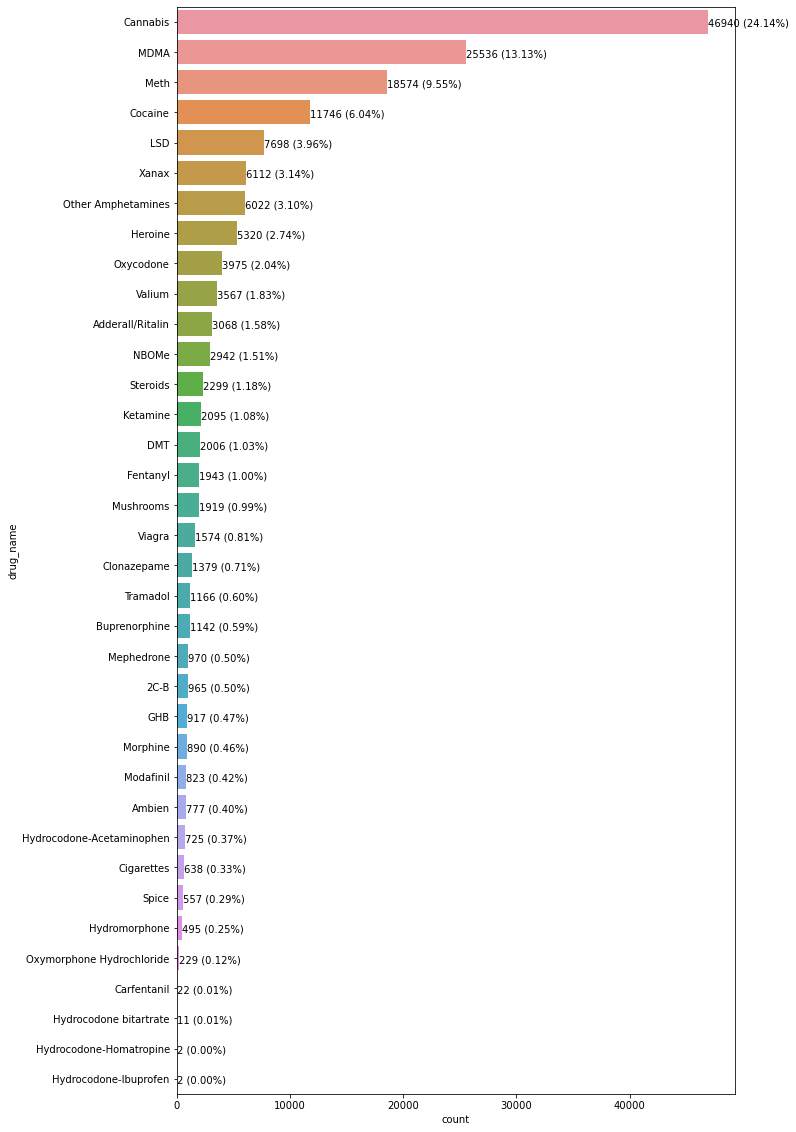

In [130]:
plt.figure(figsize=(10, 20))
ax = sns.countplot(y='drug_name', data=df, order=df["drug_name"].value_counts().head(40).index);
total = len(df)
for p in ax.patches:
    percentage = 100 * p.get_width() / total
    ax.annotate(f'{p.get_width()} ({percentage:.2f}%)', (p.get_width(), p.get_y()+0.55))

We can also group some of the drugs into the same categories to get a simpler overview:

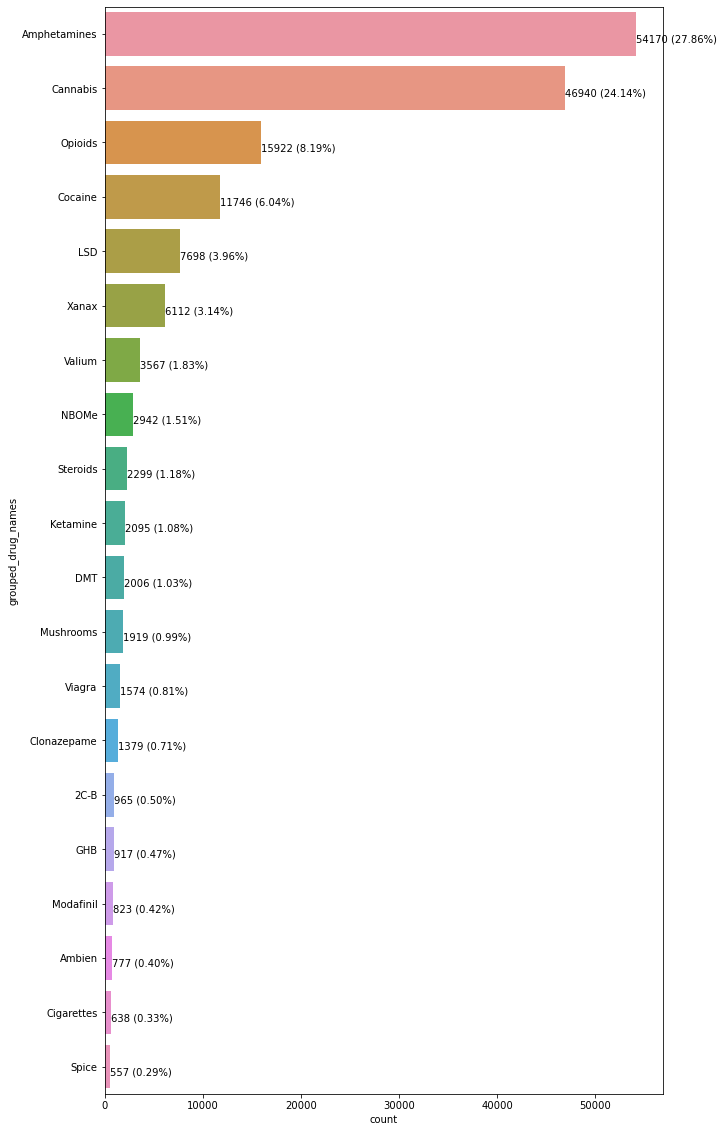

In [146]:
grouped_drug_names_dict = {v: "Opioids" for k,v in opioids_dict.items()}
grouped_drug_names_dict.update({v: "Amphetamines" for k,v in amphetamines_dict.items()})
df["grouped_drug_names"] = drug_names.replace(grouped_drug_names_dict)

plt.figure(figsize=(10, 20))
ax = sns.countplot(y='grouped_drug_names', data=df, order=df["grouped_drug_names"].value_counts().head(40).index);
total = len(df)
for p in ax.patches:
    percentage = 100 * p.get_width() / total
    ax.annotate(f'{p.get_width()} ({percentage:.2f}%)', (p.get_width(), p.get_y()+0.55))

We can see that Amphetamine-related products are the most common, making up around one quarter of all listings in the various marketplaces.

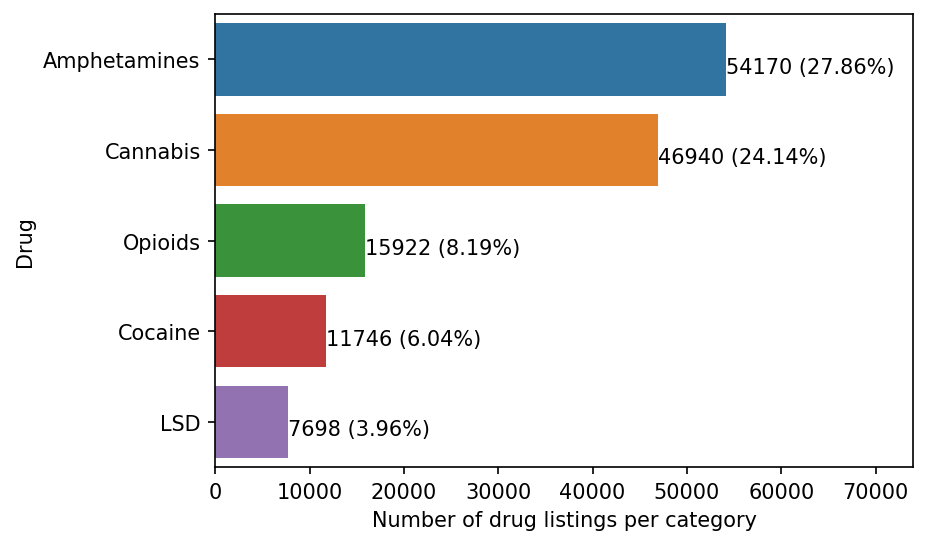

In [164]:
#plt.figure(figsize=(10, 20))
plt.figure(dpi=150)
ax = sns.countplot(y='grouped_drug_names', data=df, order=df["grouped_drug_names"].value_counts().head(5).index);
total = len(df)
for p in ax.patches:
    percentage = 100 * p.get_width() / total
    ax.annotate(f'{p.get_width()} ({percentage:.2f}%)', (p.get_width(), p.get_y()+0.55))
xlim = plt.gca().get_xlim()
plt.xlim([xlim[0], xlim[1]*1.3]);
plt.ylabel("Drug");
plt.xlabel("Number of drug listings per category")
plt.savefig("5_most_common_drugs.pdf", bbox_inches="tight");

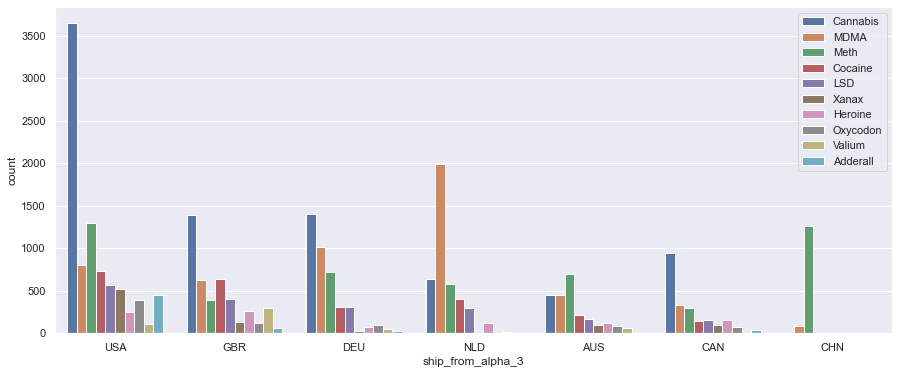

In [16]:
#plt.figure(figsize=(10, 15))
plt.figure(figsize=(15, 6))
top_drug_shipping_countries = df["ship_from_alpha_3"].value_counts().head(7).index
top_drug_types = df["drug_name"].value_counts().head(10).index
filtered_df = df[df["drug_name"].isin(top_drug_types) & df["ship_from_alpha_3"].isin(top_drug_shipping_countries)]
ax = sns.countplot(x="ship_from_alpha_3", hue="drug_name", data=filtered_df, order=top_drug_shipping_countries, hue_order=top_drug_types);
plt.legend(loc="upper right");

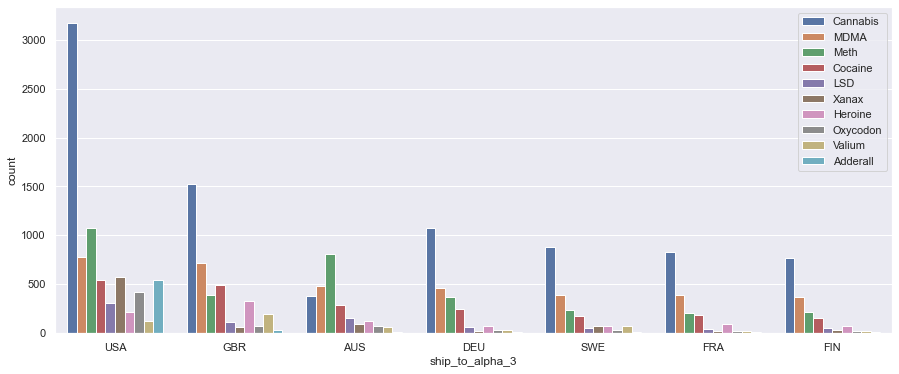

In [50]:
ship_to_alpha_3 = df["ship_to_alpha_3"].dropna()
ship_to_countries = ship_to_alpha_3.str.split(",")
df_ship_to_countries_as_list_and_drug_names = ship_to_countries.to_frame()
df_ship_to_countries_as_list_and_drug_names["drug_name"] = df["drug_name"]
df_ship_to_countries_as_list_and_drug_names = df_ship_to_countries_as_list_and_drug_names.explode("ship_to_alpha_3")

plt.figure(figsize=(15, 6))
top_drug_receiving_countries = df_ship_to_countries_as_list_and_drug_names["ship_to_alpha_3"].value_counts().head(7).index
top_drug_types = df["drug_name"].value_counts().head(10).index
filtered_df = df_ship_to_countries_as_list_and_drug_names[
    df_ship_to_countries_as_list_and_drug_names["drug_name"].isin(top_drug_types) & 
    df_ship_to_countries_as_list_and_drug_names["ship_to_alpha_3"].isin(top_drug_receiving_countries)
]
ax = sns.countplot(x="ship_to_alpha_3", hue="drug_name", data=filtered_df, order=top_drug_receiving_countries, hue_order=top_drug_types);
plt.legend(loc="upper right");

## Price

As we can see in the samples shown below, the price column is also has quite a few problems associated with it:
* Most prices are given in Bitcoin (BTC). To convert them to the second most common currency (US Dollars (USD)), we would need the exact dates when the listings were published, since the Bitcoin price has changed drastically since the time that the darknet markets we analyzed here were active (around 2014/2015). Since we do not have this information, we unfortunately have to discard most of the price data, leading to the question how representative our highly reduced dataset will be with the information that is left.
* Different symbols are used interchangeably (e.g.`BTC` and `฿` or `USD` and `$`), their order can change (e.g. `12.50 USD` and `USD 121.34`). This is less of a problem than the Bitcoin prices, since we could use manual parsing rules to handle most of the cases.
* Prices are not standardized (e.g. price per gram): The quantity of the drug is often contained in the title or description of a listing (e.g. `30 mg - Oxycodone "M" Brand`, `2 gr -- Pure Power Plant -- (Indoor)`, ...) and in rare cases also in the `price` column (`12.50 USD for 1G`). To really work with the price information (e.g. comparing the prices per marketplace/drug/country/...), we would need to extract this information as well, which is much more complicated.

In [274]:
df.price.sample(50)

84889      0.16871230 BTC
110032     0.35280835 BTC
144716         BTC 0.9425
105934     1.67440614 BTC
47394      0.01187096 BTC
75684      0.57572979 BTC
168505    15 EUR  (0.05 )
151090            400 USD
170462          ฿0.086197
80211      0.00134529 BTC
123141     0.02557796 BTC
132354         BTC 1.1002
124598     0.05715755 BTC
123226     0.25287646 BTC
149532             40 USD
35498      0.70815450 BTC
187665          ฿2.062396
60284      0.09946803 BTC
54642      0.19296482 BTC
22250      0.20400516 BTC
10366      6.29441624 BTC
171080          ฿0.440002
173743          ฿2.205000
15739      0.38549542 BTC
116739     0.23500000 BTC
114660     0.15756302 BTC
136687         BTC 0.2685
39642      0.31754664 BTC
6265       1.57098613 BTC
91535      0.29193883 BTC
73823      0.30353107 BTC
146642    208.19 USD - FE
36999      0.10829723 BTC
132372         BTC 0.0536
16910      0.46355629 BTC
75580      0.15789473 BTC
113072     0.03372859 BTC
108025     0.49186293 BTC
25153      0

Although it could be interesting to have the extracted price data, not many entries have this information if we only consider prices in USD (for example, as shown below, if we would like to check drug prices per country, we would only have around 8k of 200k entries left for such an analysis, which might then lead to results that are not very representative). For this reason, we do not extract the prices here.

In [275]:
(df.price.str.contains(r"USD|\$").fillna(False) & df["ship_from"].notnull()).sum()

8233

In [19]:
df

,product_title,product_description,ship_from,ship_to,seller,price,source,ship_to_alpha_3,ship_from_alpha_3,drug_name
0,10mg Diazepam Tabletten - 10 Stück,- 10mg Diazepam Tabletten - 10 Stück\n\n- Disk...,Germany,Worldwide,1XAnOYMoUsX1BXx,$67.01,1776,NaN,DEU,Valium
1,10mg Diazepam Tabletten - 50 Stück,10 mg Diazepam / Valium / Valocordin Tabletten...,Germany,Worldwide,1XAnOYMoUsX1BXx,$93.82,1776,NaN,DEU,Valium
2,Sonderpreis !!! 10x Diazepam Tropfen 25ml,Diazepam / Valium / Valocordin Tropfen je Flas...,Germany,Worldwide,1XAnOYMoUsX1BXx,$938.32,1776,NaN,DEU,Valium
3,Sonderpreis !!! 2x Diazepam Tropfen 25ml,Diazepam / Valium / Valocordin Tropfen je Flas...,Germany,Worldwide,1XAnOYMoUsX1BXx,$214.46,1776,NaN,DEU,Valium
4,1 gr indian Ketamin,Very Strong Ketamin from India be careful\n\ni...,Austria,Worldwide,ACAB23,$50.00,1776,NaN,AUT,Ketamine
...,...,...,...,...,...,...,...,...,...,...
194428,∎∎ W. Domino XTC ∎∎ 220MG,White Domino XTC Pills from the Netherlands\n\...,Netherlands,NaN,"∎∎ Sensi ▬ XTC, MDMA & THC",USD 42.86\nfor 5 Pills,themarketplace,NaN,NLD,MDMA
194429,∎∎ White Domino XTC ► 220mg,White Domino XTC Pills from the Netherlands\n\...,Netherlands,NaN,"∎∎ Sensi ▬ XTC, MDMA & THC",USD 42.48\nfor 5 Pills,themarketplace,NaN,NLD,MDMA
194430,∎∎ White Domino XTC ► 220mg,White Domino XTC Pills from the Netherlands\n\...,Netherlands,NaN,"∎∎ Sensi ▬ XTC, MDMA & THC",USD 42.82\nfor 5 Pills,themarketplace,NaN,NLD,MDMA
194431,∎∎ Yellow Grenades ∎∎ 170MG,White Domino XTC Pills from the Netherlands\n\...,Europe,NaN,"∎∎ Sensi ▬ XTC, MDMA & THC",USD 30.08\nfor 5 Pills,themarketplace,NaN,NaN,MDMA


In [28]:
df[df["drug_name"].isin(df["drug_name"].value_counts().head(5).index)]

,product_title,product_description,ship_from,ship_to,seller,price,source,ship_to_alpha_3,ship_from_alpha_3,drug_name
6,100g SPEED PASTE (wet),SPEED PASTE - (Amphetamine)\n\n***Very good ...,Hungary,Worldwide,BruceWillix,$490.00,1776,NaN,HUN,Meth
7,10g AFGHAN KUSH - Outdoor Weed (Very Strong!!!),„AFGHAN KUSH” - Outdoor WEED (Very Strong!!!)...,Hungary,Worldwide,BruceWillix,$100.00,1776,NaN,HUN,Cannabis
8,10g CHOCOLATE FONDUE - Specific Outdoor Weed (...,„CHOCOLATE FONDUE” - Specific Outdoor WEED (...,Hungary,Worldwide,BruceWillix,$90.00,1776,NaN,HUN,Cannabis
9,10g CRYSTAL SKUNK – Special Indoor Weed for Sp...,„CRYSTAL SKUNK” - Indoor WEED (High Quality!!...,Hungary,Worldwide,BruceWillix,$120.00,1776,NaN,HUN,Cannabis
10,10g SPEED - NORMAL DRY,>>>IMPORTANT - Before placing your order pleas...,Hungary,Worldwide,BruceWillix,$100.00,1776,NaN,HUN,Meth
...,...,...,...,...,...,...,...,...,...,...
194428,∎∎ W. Domino XTC ∎∎ 220MG,White Domino XTC Pills from the Netherlands\n\...,Netherlands,NaN,"∎∎ Sensi ▬ XTC, MDMA & THC",USD 42.86\nfor 5 Pills,themarketplace,NaN,NLD,MDMA
194429,∎∎ White Domino XTC ► 220mg,White Domino XTC Pills from the Netherlands\n\...,Netherlands,NaN,"∎∎ Sensi ▬ XTC, MDMA & THC",USD 42.48\nfor 5 Pills,themarketplace,NaN,NLD,MDMA
194430,∎∎ White Domino XTC ► 220mg,White Domino XTC Pills from the Netherlands\n\...,Netherlands,NaN,"∎∎ Sensi ▬ XTC, MDMA & THC",USD 42.82\nfor 5 Pills,themarketplace,NaN,NLD,MDMA
194431,∎∎ Yellow Grenades ∎∎ 170MG,White Domino XTC Pills from the Netherlands\n\...,Europe,NaN,"∎∎ Sensi ▬ XTC, MDMA & THC",USD 30.08\nfor 5 Pills,themarketplace,NaN,NaN,MDMA


In [29]:
df[df["drug_name"].isin(df["drug_name"].value_counts().head(5).index)].groupby(["ship_from_alpha_3", "drug_name"]).count()

product_title  product_description  ship_from  \
ship_from_alpha_3 drug_name                                                  
AND               Cannabis               7                    7          7   
ARG               Cocaine               17                   17         17   
                  MDMA                   1                    1          1   
AUS               Cannabis             447                  447        447   
                  Cocaine              218                  218        218   
...                                    ...                  ...        ...   
USA               LSD                  573                  573        573   
                  MDMA                 797                  797        797   
                  Meth                1297                 1297       1297   
ZAF               Cannabis              79                   79         79   
                  Meth                  29                   29         29   

                             ship_to  seller  price  source  ship_to_alpha_3  
ship_from_alpha_3 drug_name                                                   
AND               Cannabis         7       7      7       7                0  
ARG               Cocaine         13      17     17      17                0  
                  MDMA             1       1      1       1                0  
AUS               Cannabis       373     447    442     447              334  
                  Cocaine        214     218    218     218              211  
...                              ...     ...    ...     ...              ...  
USA               LSD            531     573    573     573              249  
                  MDMA           740     797    797     797              642  
                  Meth          1154    1297   1295    1297              840  
ZAF               Cannabis        60      79     79      79                0  
                  Meth            29      29     29      29                0  

[160 rows x 8 columns]

In [30]:
df["ship_to_alpha_3"].value_counts()

USA                                                                                                                11986
AUS                                                                                                                 3812
GBR                                                                                                                 3383
AUT,BEL,BGR,HRV,CYP,CZE,DNK,EST,FIN,FRA,DEU,GRC,HUN,IRL,ITA,LVA,LTU,LUX,MLT,NLD,POL,PRT,ROU,SVK,SVN,ESP,SWE,GBR     1634
DEU                                                                                                                  935
                                                                                                                   ...  
AUT,BEL,CHE,DEU,ESP,FRA,ITA,LUX,NLD                                                                                    1
AUT,BEL,CHE,DEU,ESP,FRA,GBR,ITA,LUX,NLD                                                                                1
AUT,BEL,BGR,HRV,CZE,DNK,EST,FRA,

In [23]:
df_country_statistics = df["ship_from_alpha_3"].value_counts().to_frame()
df_country_statistics["ship_to_alpha_3"] = df["ship_to_alpha_3"].value_counts()
df_country_statistics["drug_name"] = df["drug_name"].value_counts()
df_country_statistics

,ship_from_alpha_3,ship_to_alpha_3,drug_name
USA,12723,11986.0,NaN
GBR,6794,3383.0,NaN
DEU,5030,935.0,NaN
NLD,4813,73.0,NaN
AUS,3565,3812.0,NaN
...,...,...,...
GMB,1,NaN,NaN
SLV,1,NaN,NaN
CHL,1,NaN,NaN
GGY,1,NaN,NaN


---
Finally, let's save the cleaned data for later use:

In [147]:
df.to_csv("../dat/drug_listings_cleaned.csv")